<a id="top"></a>
# Getting Started with the Iguazio Data Science Platform

## Overview <a id="gs-overview"></a>



1. [Create and configure a new project](#gs-step-project-create-n-config)
2. [Ingest a data set](#gs-step-ingest-data)
3. [Explore the data](#gs-step-explore-data)
4. [Run model training at scale](#gs-step-run-model-training)
5. [Test your model](#gs-step-test-model)
6. [Create and run a fully automated ML pipeline](#gs-step-create-n-run-ml-pipeline)



## Step 1: Create and Configure a New Project <a id="gs-step-project-create-n-config"></a>

### Create a New Project <a id="gs-create-project"></a>

In [1]:
from os import path, getenv
from mlrun import new_project

project_name = '-'.join(filter(None, ['rapid-prototype', getenv('V3IO_USERNAME', None)]))
project_path = path.abspath('conf')
project = new_project(project_name, project_path, init_git=True)

print(f'Project path: {project_path}\nProject name: {project_name}')

Project path: /User/rapid-proto/conf
Project name: rapid-prototype-michaelk


### Configure MLRun <a id="gs-mlrun-config"></a>

In [2]:
from mlrun import run_local, NewTask, mlconf, import_function, mount_v3io

# Target location for storing pipeline artifacts
artifact_path = path.abspath('artifacts')
# MLRun DB path or API service URL
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

print(f'Artifacts path: {artifact_path}\nMLRun DB path: {mlconf.dbpath}')

Artifacts path: /User/rapid-proto/artifacts
MLRun DB path: http://mlrun-api:8080


#### Import Nuclio <a id="gs-nuclio-import"></a>


In [3]:
import nuclio

In [4]:
# nuclio: start-code

In [5]:
%nuclio config spec.build.baseImage = "mlrun/ml-models"
%nuclio config kind = "job"
%nuclio cmd -c pip install v3io-frames==0.6.18

%nuclio: setting spec.build.baseImage to 'mlrun/ml-models'
%nuclio: setting kind to 'job'


## Step 2: Take a Snapshot Data Set of the KV feature table <a id="gs-step-ingest-data"></a>


### Initialization <a id="gs-step-ingest-data-init"></a>


In [6]:
# nuclio: ignore
# Set the source-data URL
container = 'users'
table_path = path.join(getenv('V3IO_USERNAME'),'examples/rapid-prototype/feature-table')
columns = ['label', 'socioeconomic_idx', 
           'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 
           'bet_sum', 'bet_mean', 'bet_count' ,'bet_var',
           'win_sum', 'win_mean', 'win_count' ,'win_var']
format = 'csv'

### Define a Data-Snapshot Function <a id="gs-step-ingest-data-define-function"></a>


In [7]:
from os import path
import pandas as pd
import v3io_frames as v3f


# Ingest a data set into the platform
def snapshot_data(context, container, table_path, columns, format='csv'):
    
    client = v3f.Client("framesd:8081", container=container)
    client.execute(backend="kv", table=table_path, command="infer")
    df = client.read('kv', table_path, columns=columns)
    
    target_path = path.join(context.artifact_path, 'data')
    # Optionally print data to your logger
    context.logger.info('Saving snapshot data set to {} ...'.format(target_path))
    
    # Store the data set in your artifacts database
    context.log_dataset('snapshot_dataset', df=df, format=format,
                        index=False, artifact_path=target_path)

In [8]:
# nuclio: end-code

<a id='gs-run-ingest-func-local'></a>
#### Run the Function Locally in Jupyter Notebook

In [10]:
# Run the data-ingestion function locally in Jupyter Notebook
snapshot_data_run = run_local(name='snapshot_data',
                         handler=snapshot_data,
                         params={'container': container, 'table_path': table_path, 
                                 'columns':columns, 'format': format},
                         project=project_name, artifact_path=artifact_path)

> 2020-07-29 15:00:56,228 [info] starting run snapshot_data uid=02eba309aa2c45b8abaa7710ecf5ce1b  -> http://mlrun-api:8080
> 2020-07-29 15:00:56,361 [info] Saving snapshot data set to /User/rapid-proto/artifacts/data ...


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
rapid-prototype-michaelk,...ecf5ce1b,0,Jul 29 15:00:56,completed,snapshot_data,v3io_user=michaelkkind=handlerowner=michaelkhost=jupyter-mk-7c7fc6cc67-fkkvj,,"container=userstable_path=michaelk/examples/rapid-prototype/feature-tablecolumns=['label', 'socioeconomic_idx', 'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 'bet_sum', 'bet_mean', 'bet_count', 'bet_var', 'win_sum', 'win_mean', 'win_count', 'win_var']format=csv",,snapshot_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run 02eba309aa2c45b8abaa7710ecf5ce1b --project rapid-prototype-michaelk , !mlrun logs 02eba309aa2c45b8abaa7710ecf5ce1b --project rapid-prototype-michaelk
> 2020-07-29 15:00:56,566 [info] run executed, status=completed


#### Run the Function on a Cluster <a id="gs-run-ingest-func-cluster"></a>


In [11]:
from mlrun import code_to_function

# Convert the local snapshot_data function into a gen_func project function
gen_func = code_to_function(name='snapshot-data')
project.set_function(gen_func)
snapshot_data_func = project.func('snapshot-data').apply(mount_v3io())

In [ ]:
#Build image
snapshot_data_func.deploy()

##### Run the Function on the Cluster <a id="gs-run-ingest-func-on-the-cluster-run-function"></a>


In [22]:

snapshot_data_run = snapshot_data_func.run(name='snapshot_data',
                                 handler='snapshot_data',
                                 params={'container': container, 'table_path': table_path, 
                                         'columns':columns, 'format': format},
                                 artifact_path=artifact_path)

> 2020-07-29 15:16:38,321 [info] starting run snapshot_data uid=5dcc610f868c4756b616ba5f77fa3852  -> http://mlrun-api:8080
> 2020-07-29 15:16:38,467 [info] Job is running in the background, pod: snapshot-data-zmjdz
> 2020-07-29 15:16:43,707 [info] Saving snapshot data set to /User/rapid-proto/artifacts/data ...
> 2020-07-29 15:16:43,846 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
rapid-prototype-michaelk,...77fa3852,0,Jul 29 15:16:43,completed,snapshot_data,v3io_user=michaelkkind=jobowner=michaelkhost=snapshot-data-zmjdz,,"container=userstable_path=michaelk/examples/rapid-prototype/feature-tablecolumns=['label', 'socioeconomic_idx', 'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 'bet_sum', 'bet_mean', 'bet_count', 'bet_var', 'win_sum', 'win_mean', 'win_count', 'win_var']format=csv",,snapshot_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run 5dcc610f868c4756b616ba5f77fa3852 --project rapid-prototype-michaelk , !mlrun logs 5dcc610f868c4756b616ba5f77fa3852 --project rapid-prototype-michaelk
> 2020-07-29 15:16:47,649 [info] run executed, status=completed


## Step 3: Explore the Data <a id="gs-step-explore-data"></a>


### Explore the Data with Pandas DataFrames <a id="gs-explore-data-w-pandas-df"></a>


Run the following code to use pandas DataFrames to read your data set, extract some basic statistics, and display them.

In [23]:
# Read your data set
from mlrun.run import get_dataitem
df = get_dataitem(snapshot_data_run.outputs['snapshot_dataset']).as_df()

In [24]:
# Display a portion of the read data
df.head()

,label,socioeconomic_idx,purchase_sum,purchase_mean,purchase_count,purchase_var,bet_sum,bet_mean,bet_count,bet_var,win_sum,win_mean,win_count,win_var
0,1,4,5575,50,114,141,8008,9,855,5,2224.0,202.0,11.0,1608.0
1,1,1,5470,50,109,154,8172,11,867,8,1310.0,186.0,7.0,1612.0
2,1,2,4532,51,93,128,7342,9,787,5,1730.0,214.0,8.0,1922.0
3,1,2,3892,50,79,163,7990,10,841,5,1360.0,194.0,7.0,1555.0
4,1,7,4681,52,92,166,7064,11,730,7,880.0,147.0,6.0,793.0


In [25]:
# Calculate and display the number of data-set items
print(f'Total number of rows: {len(df)}')

Total number of rows: 1958


In [26]:
# Display statistics grouped by label
df.groupby(['label']).describe()

socioeconomic_idx                                               \
                  count      mean       std  min  25%  50%  75%  max   
label                                                                  
0                 559.0  5.048301  1.815749  1.0  4.0  5.0  6.0  7.0   
1                1399.0  2.998570  1.846777  1.0  2.0  3.0  4.0  7.0   

      purchase_sum               ... win_count       win_var               \
             count         mean  ...       75%   max   count         mean   
label                            ...                                        
0            559.0  1589.847943  ...      24.0  54.0   547.0  2068.414991   
1           1399.0  4311.554682  ...      10.5  22.0  1399.0  2176.924946   

                                                          
               std  min     25%     50%     75%      max  
label                                                     
0      1046.328294  0.0  1633.5  2097.0  2504.0  10658.0  
1       960.046169  0.0  1611.0  2155.0  2689.5  12800.0  

[2 rows x 104 columns]

### Explore the Data with an MLRun Marketplace Function <a id="gs-explore-data-w-mlrun-func"></a>


#### Add an Exploration Function <a id="gs-explore-data-w-mlrun-func-add-func"></a>


In [27]:
project.set_function('hub://describe', 'describe')
describe = project.func('describe').apply(mount_v3io())

#### Run the Exploration Function <a id="gs-explore-data-w-mlrun-func-run-func"></a>


In [28]:
describe_run = describe.run(params={'label_column': 'label'},
                            inputs={"table":
                                    snapshot_data_run.outputs['snapshot_dataset']},
                            artifact_path=artifact_path)

> 2020-07-29 15:17:18,419 [info] starting run describe-summarize uid=65f50712384a4aa2b175608f7968e2fb  -> http://mlrun-api:8080
> 2020-07-29 15:17:18,559 [info] Job is running in the background, pod: describe-summarize-kvlgn
> 2020-07-29 15:18:08,758 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
rapid-prototype-michaelk,...7968e2fb,0,Jul 29 15:17:24,completed,describe-summarize,v3io_user=michaelkkind=jobowner=michaelkhost=describe-summarize-kvlgn,table,label_column=label,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run 65f50712384a4aa2b175608f7968e2fb --project rapid-prototype-michaelk , !mlrun logs 65f50712384a4aa2b175608f7968e2fb --project rapid-prototype-michaelk
> 2020-07-29 15:18:17,955 [info] run executed, status=completed


#### Review the Run Output <a id="gs-explore-data-w-mlrun-func-run-output-review"></a>



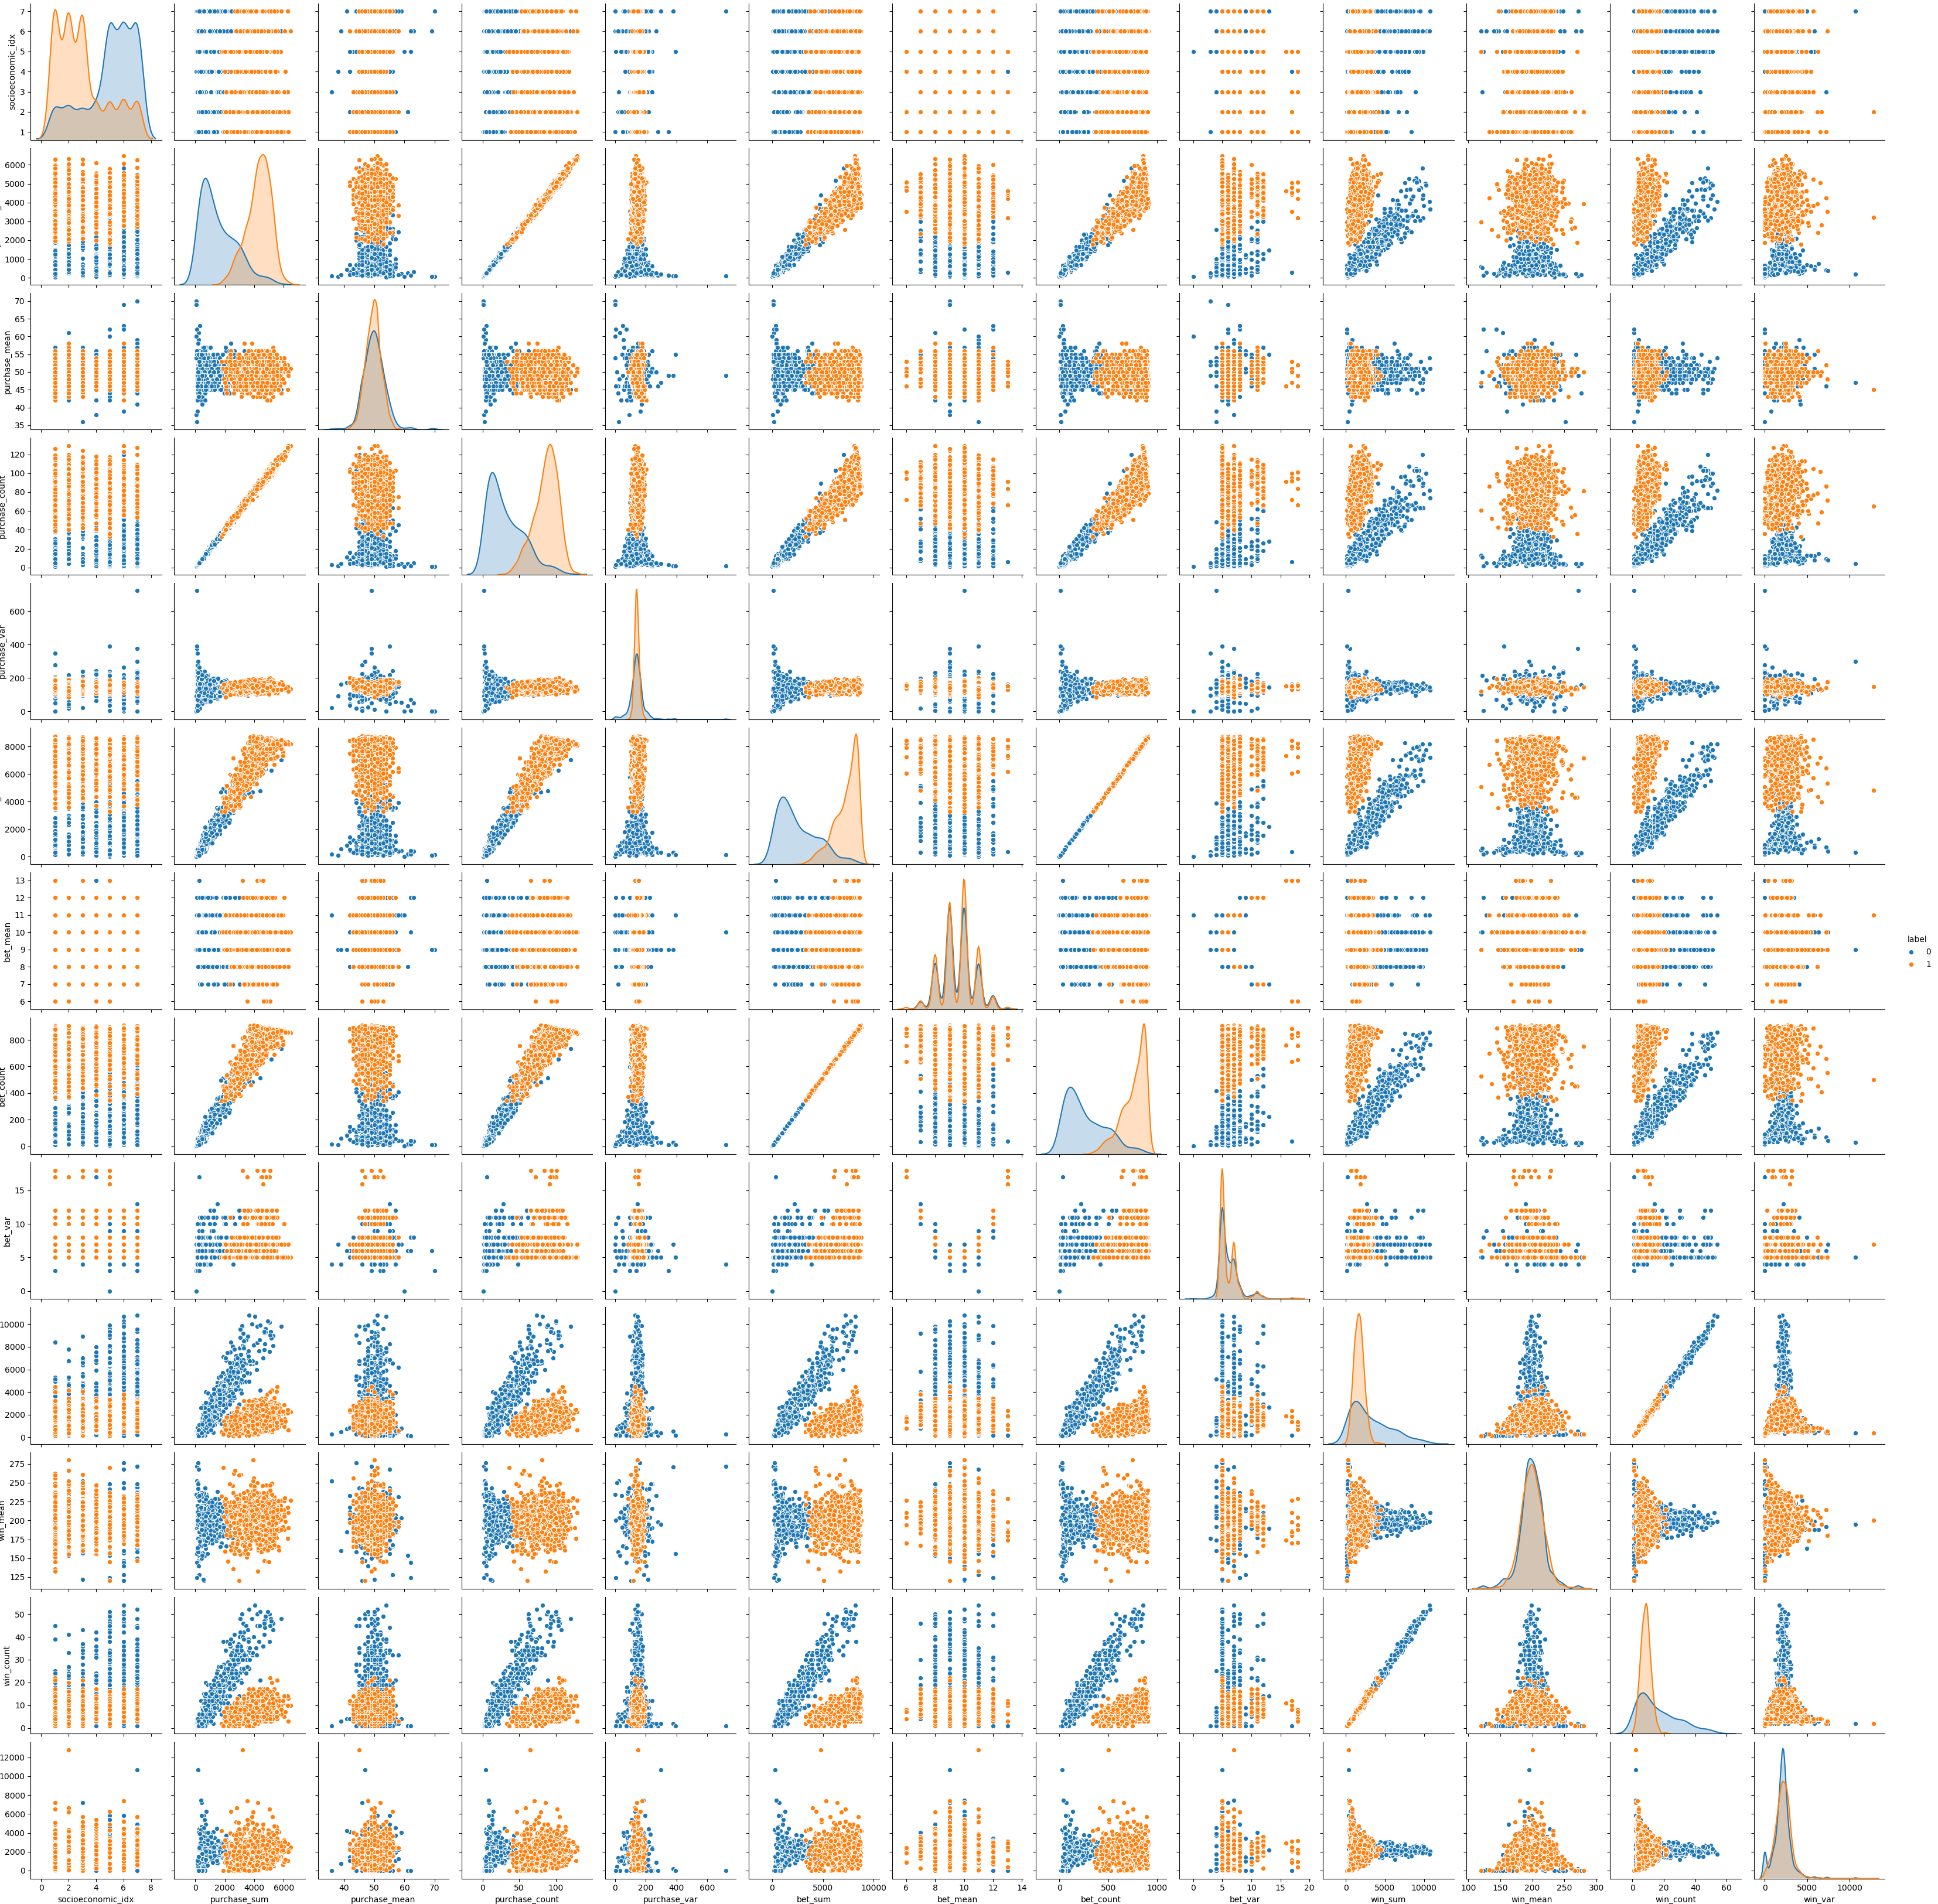

In [29]:
from IPython.display import display, HTML

# Display the `histograms` artifact
display(HTML('<h3>Histograms</h3>'), HTML(describe_run.outputs['histograms']))


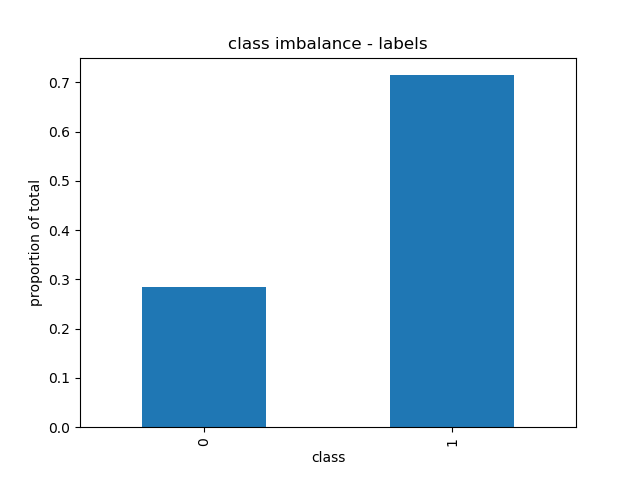

In [30]:
# Display the `imbalance` artifact
display(HTML('<h3>Imbalance<h3>'),
        HTML(filename=describe_run.outputs['imbalance']))


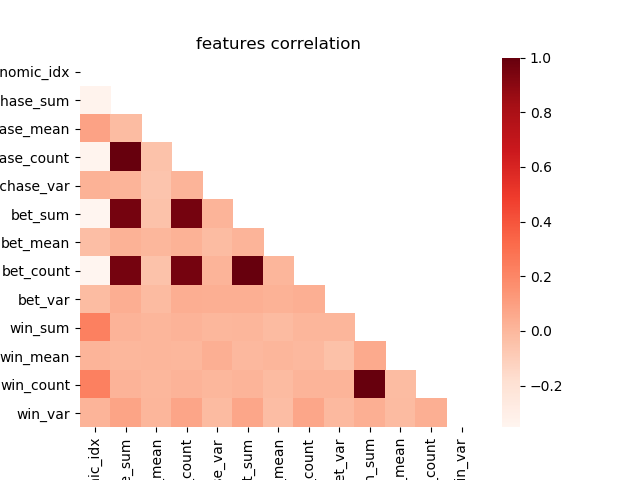

In [31]:
# Display the `correlation` artifact
display(HTML('<h3>Correlation Matrix<h3>'),
        HTML(filename=describe_run.outputs['correlation']))

## Step 4: Run Model Training at Scale <a id="gs-step-run-model-training"></a>


#### Add a Training Function <a id="gs-train-model-add-func"></a>


In [32]:
project.set_function('hub://sklearn_classifier', 'train')
train = project.func('train').apply(mount_v3io())

#### Run a Model-Training Task <a id="gs-train-model-run-task"></a>


In [33]:
# Configure the models to train
models = ["sklearn.ensemble.RandomForestClassifier", 
          "sklearn.linear_model.LogisticRegression",
          "sklearn.ensemble.AdaBoostClassifier"]

In [34]:
# Create a training task
train_task = NewTask(name="train",
                     params={"sample": -1,
                             "label_column": "label",
                             "test_size": 0.10},
                     inputs={"dataset": snapshot_data_run.outputs['snapshot_dataset']})

# Run the training task
train_run = train.run(train_task.with_hyper_params({'model_pkg_class': models},
                                                   selector='max.accuracy'),
                      artifact_path=artifact_path)

> 2020-07-29 15:21:52,587 [info] starting run train uid=f515417fb0a54ba79840f0225dc844b0  -> http://mlrun-api:8080
> 2020-07-29 15:21:52,724 [info] Job is running in the background, pod: train-2sj4h
> 2020-07-29 15:22:02,120 [info] best iteration=1, used criteria max.accuracy
> 2020-07-29 15:22:02,387 [info] run executed, status=completed
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...5dc844b0,0,Jul 29 15:21:57,completed,train,v3io_user=michaelkkind=jobowner=michaelk,dataset,sample=-1label_column=labeltest_size=0.1,best_iteration=1accuracy=1.0test-error=0.0rocauc=1.0brier_score=0.0014123287671232874f1-score=1.0precision_score=1.0recall_score=1.0,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodeliteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run f515417fb0a54ba79840f0225dc844b0 --project default , !mlrun logs f515417fb0a54ba79840f0225dc844b0 --project default
> 2020-07-29 15:22:11,954 [info] run executed, status=completed


### Review the Run Output <a id="gs-train-model-run-output-review"></a>



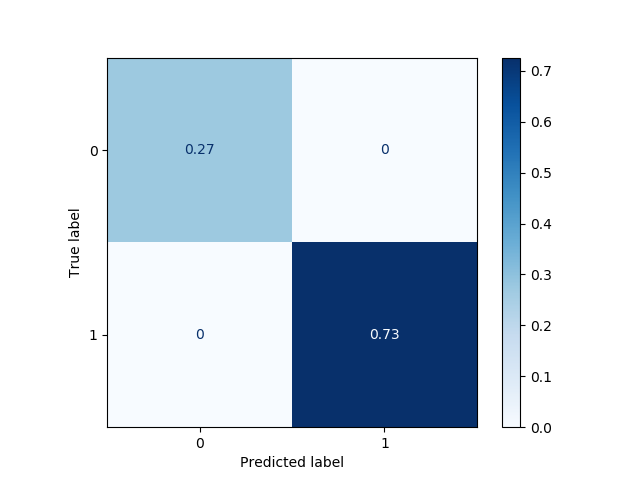


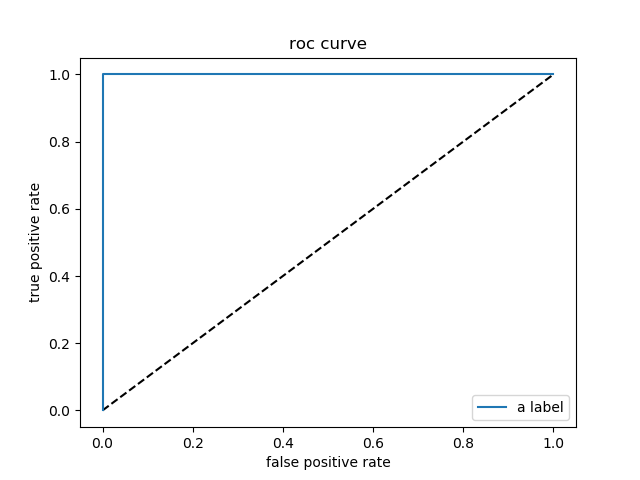

In [35]:
# Display the name of the selected model
display(HTML(f'<b>Best model:</b> '
             f'{models[train_run.outputs["best_iteration"]-1]}'))

# Display the accuracy for the optimal run iteration
display(HTML(f'<b>Accuracy:</b> {train_run.outputs["accuracy"]}'))

# Display HTML output artifacts
display(HTML('<h3>Confusion Matrix:</h3>'),
        HTML(filename=train_run.outputs['confusion-matrix']))
display(HTML('<h3>ROC Curve:</h3>'), HTML(filename=train_run.outputs['roc-binary']))

## Step 5: Test Your Model <a id="gs-step-test-model"></a>


In [36]:
project.set_function('hub://test_classifier', 'test')
test = project.func('test').apply(mount_v3io())

#### Run a Model-Testing Task <a id="gs-test-model-run-task"></a>


In [37]:
test_task = NewTask(name="test",
                    params={"label_column": "label",
                            "plots_dest": path.join("plots", "test")},
                    inputs={"models_path": train_run.outputs['model'],
                            "test_set": train_run.outputs['test_set']}
                    )
test_run = test.run(test_task,
                    artifact_path=artifact_path)

> 2020-07-29 15:23:01,766 [info] starting run test uid=63d649f68b304658ac84adaa0a78c8ef  -> http://mlrun-api:8080
> 2020-07-29 15:23:01,904 [info] Job is running in the background, pod: test-t99tc
> 2020-07-29 15:23:09,385 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...0a78c8ef,0,Jul 29 15:23:08,completed,test,v3io_user=michaelkkind=jobowner=michaelkhost=test-t99tc,models_pathtest_set,label_column=labelplots_dest=plots/test,accuracy=1.0test-error=0.0rocauc=1.0brier_score=0.00210923076923077f1-score=1.0precision_score=1.0recall_score=1.0,probability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarytest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 63d649f68b304658ac84adaa0a78c8ef --project default , !mlrun logs 63d649f68b304658ac84adaa0a78c8ef --project default
> 2020-07-29 15:23:11,077 [info] run executed, status=completed


### Review the Run Output <a id="gs-test-model-run-output-review"></a>



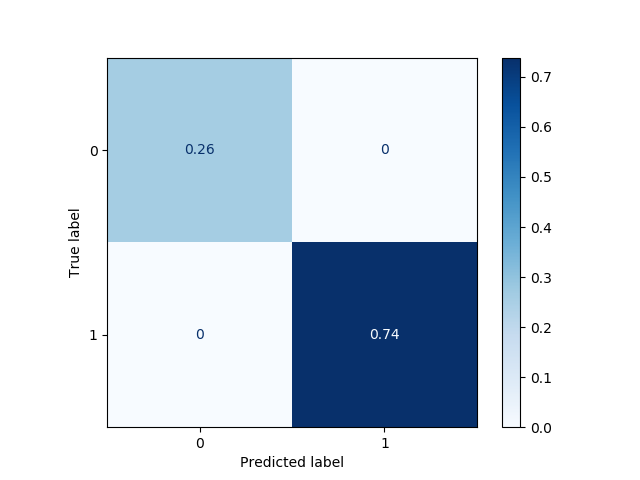


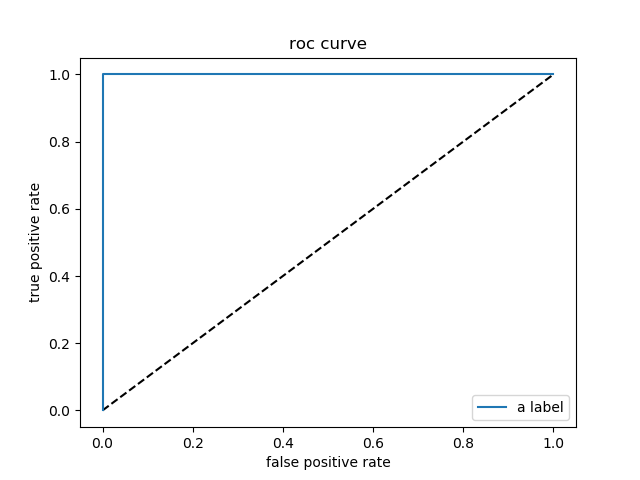

In [38]:
# Display the model accuracy
display(HTML(f'<b>Test Accuracy:</b> {test_run.outputs["accuracy"]}'))

# Display HTML output artifacts
display(HTML("<h3>Confusion matrix:</h3>"),
        HTML(filename=test_run.outputs['confusion-matrix']))
display(HTML("<h3>ROC Curve:</h3>"), HTML(filename=test_run.outputs['roc-binary']))

## Step 6: Create and Run a Fully Automated ML Pipeline <a id="gs-step-create-n-run-ml-pipeline"></a>


### Add Serving Functions from the MLRun Functions Marketplace <a id="gs-ml-pipeline-add-functions"></a>


In [39]:
project.set_function('hub://model_server:development', 'serving')
#project.set_function('hub://model_server_tester', 'serving-tester')

In [55]:
input_stream = f'users/{getenv("V3IO_USERNAME")}/examples/rapid-prototype/serving-stream@modelserver'
partitions = list(range(0,8))

serving = project.func('serving').apply(mount_v3io())
serving.set_envs({"SERVING_MODEL_rapid_proto": train_run.outputs['model'],
                 'INFERENCE_STREAM' : path.join('users', getenv('V3IO_USERNAME'), 'examples/rapid-prototype/inference-stream')})

serving.add_trigger('serving_stream', nuclio.triggers.V3IOStreamTrigger(url=input_stream, partitions=partitions))


serving.to_dict()


{'kind': 'remote',
 'metadata': {'name': 'sklearn-server',
  'hash': 'c40b8836f05c7cadc9a956d2968488f6399ec835',
  'project': 'rapid-prototype-michaelk',
  'labels': {'author': 'yaronh', 'framework': 'sklearn'},
  'categories': ['serving', 'ml']},
 'spec': {'command': 'http://192.168.226.12:31425',
  'args': [],
  'image': '',
  'description': 'generic sklearn model server',
  'min_replicas': 0,
  'max_replicas': 4,
  'volumes': [{'flexVolume': {'driver': 'v3io/fuse',
     'options': {'accessKey': 'b01eb2f1-294a-4f63-b0a6-42561e3e1706',
      'container': 'users',
      'subPath': '/michaelk'}},
    'name': 'v3io'}],
  'volume_mounts': [{'mountPath': '/User', 'name': 'v3io'}],
  'env': [{'name': 'MODEL_CLASS', 'value': 'ClassifierModel'},
   {'name': 'ENABLE_EXPLAINER', 'value': 'False'},
   {'name': 'V3IO_API', 'value': 'v3io-webapi.default-tenant.svc:8081'},
   {'name': 'V3IO_USERNAME', 'value': 'michaelk'},
   {'name': 'V3IO_ACCESS_KEY',
    'value': 'b01eb2f1-294a-4f63-b0a6-42561e3

In [56]:
# Deploy the model as a serverless function


#serving_run = serving.run(models={"SERVING_MODEL_rapid_proto": train_run.outputs['model']})



serving.deploy(project='rapid-prototype-mk')




> 2020-07-30 09:06:53,902 [info] deploy started
[nuclio] 2020-07-30 09:06:56,020 (info) Build complete
[nuclio] 2020-07-30 09:07:57,775 (error) Failed to deploy. Details:
panic: runtime error: index out of range

goroutine 1 [running]:
github.com/nuclio/nuclio/vendor/github.com/v3io/v3io-go/pkg/dataplane/http.(*context).buildRequestURI(0xc4205f0300, 0xc42051bfd0, 0x3, 0xc420424230, 0x5, 0x0, 0x0, 0xc4202dee00, 0x31, 0x2f, ...)
	/go/src/github.com/nuclio/nuclio/vendor/github.com/v3io/v3io-go/pkg/dataplane/http/context.go:1061 +0x3a7
github.com/nuclio/nuclio/vendor/github.com/v3io/v3io-go/pkg/dataplane/http.(*context).sendRequest(0xc4205f0300, 0xc42045ebd0, 0x1504e2a, 0x3, 0xc4202dee00, 0x31, 0x0, 0x0, 0xc4202613b0, 0x0, ...)
	/go/src/github.com/nuclio/nuclio/vendor/github.com/v3io/v3io-go/pkg/dataplane/http/context.go:971 +0xe7
github.com/nuclio/nuclio/vendor/github.com/v3io/v3io-go/pkg/dataplane/http.(*context).DescribeStreamSync(0xc4205f0300, 0xc42045ebd0, 0x1397aa0, 0x7fe348ad4101, 0

DeployError: cannot deploy 

In [31]:
np.array(feat).tolist()

[5.0,
 5101.0,
 47.0,
 105.0,
 134.0,
 8570.0,
 9.0,
 886.0,
 5.0,
 1872.0,
 209.0,
 9.0,
 1458.0]

In [29]:
import numpy as np
import requests
endpoint = 'http://192.168.226.12:30831/rapid_proto/predict'

feat_names = ['socioeconomic_idx','purchase_sum','purchase_mean','purchase_count','purchase_var','bet_sum','bet_mean',
 'bet_count','bet_var','win_sum','win_mean','win_count','win_var']
feat_list = [[7,799,47,17,143,1560,7,164,11,810.0,162.0,5.0,782.0],
             [5,5101,47,105,134,8570,9,886,5,1872.0,209.0,9.0,1458.0]]


for feat in feat_list:
    body = {'instances': np.array(feat).reshape(1,-1).tolist() }
    resp = requests.post(url=endpoint, json=body)
    print(resp.status_code)
    print(resp.content)
    

200
b'[0]'
200
b'[1]'


### Define and Save a Pipeline Workflow <a id="gs-pipeline-workflow-define-n-save"></a>


In [29]:
%%writefile {path.join(project_path, 'workflow.py')}

from kfp import dsl
from mlrun import mount_v3io

funcs = {}
DATASET = 'snapshot_data'
LABELS = "label"
MODELS = ["sklearn.ensemble.RandomForestClassifier",
          "sklearn.linear_model.LogisticRegression",
          "sklearn.ensemble.AdaBoostClassifier"]


# Configure function resources and local settings
def init_functions(functions: dict, project=None, secrets=None):
    for f in functions.values():
        f.apply(mount_v3io())

    functions['serving'].metadata.name = 'rapid-proto-serving'


# Create a Kubeflow Pipelines pipeline
@dsl.pipeline(
    name="rapid-proto-pipe",
    description="rapid proto training-serving pipe"
)
def kfpipeline(source_url='http://iguazio-sample-data.s3.amazonaws.com/iris_dataset.csv'):

    # Ingest the data set
    ingest = funcs['snapshot-data'].as_step(
        name="snapshot-data",
        handler='get_data',
        inputs={'source_url': source_url},
        params={'format': 'pq'},
        outputs=[DATASET])

    # Analyze the dataset
    describe = funcs["describe"].as_step(
        name="summary",
        params={"label_column": LABELS},
        inputs={"table": ingest.outputs[DATASET]})

    # Train a model with hyperparemeters
    train = funcs["train"].as_step(
        name="train",
        params={"sample": -1,
                "label_column": LABELS,
                "test_size": 0.10},
        hyperparams={'model_pkg_class': MODELS},
        selector='max.accuracy',
        inputs={"dataset": ingest.outputs[DATASET]},
        outputs=['model', 'test_set'])

    # Test and visualize the model
    test = funcs["test"].as_step(
        name="test",
        params={"label_column": LABELS},
        inputs={"models_path": train.outputs['model'],
                "test_set": train.outputs['test_set']})

    # Deploy the model as a serverless function
    deploy = funcs["serving"].deploy_step(
        models={f"{DATASET}_v1": train.outputs['model']})

    # Test the new model server (via REST API calls)
    tester = funcs["serving-tester"].as_step(
        name='serving-tester',
        params={'addr': deploy.outputs['endpoint'], 'model': f"{DATASET}_v1"},
        inputs={'table': train.outputs['test_set']})

Writing /User/getting-started-tutorial/conf/workflow.py


#### Register the Workflow <a id="gs-register-workflow"></a>


Use the `set_workflow` MLRun project method to register your workflow with MLRun.
The following code sets the `name` parameter to the selected workflow name ("main") and the `code` parameter to the name of the workflow file that is found in your project directory (**workflow.py**).

In [30]:
# Register the workflow file as "main"
project.set_workflow('main', 'workflow.py')

### Save Your Project Configuration <a id="gs-save-project"></a>


Use the `save` MLRun project method to save your project definitions to a project-configuration file in your project directory (**/User/getting-started-tutorial/conf**).
The default name of the project file is **project.yaml**, but you can optionally change it by setting the `filepath` parameter of the `save` method.

> **Note:** It's recommended that you commit your project-configuration file and any future changes to this file to a Git repository.

In [31]:
project.save()

<a id='gs-pipeline-workflow-run'></a>
### Run Your Pipeline Workflow

Use the `run` MLRun project method to execute your workflow pipeline with Kubeflow Pipelines.
The tutorial code sets the following method parameters; (for the full parameters list, see the MLRun documentation or embedded help):

- **`name`** &mdash; the workflow name (in this case, "main" &mdash; see the previous step).
- **`arguments`** &mdash; A dictionary of Kubeflow Pipelines arguments (parameters).
  The tutorial code sets this parameter to an empty arguments list (`{}`), but you can edit the code to add arguments.
- **`artifact_path`** &mdash; a path or URL that identifies a location for storing the workflow artifacts.
  You can use `{{workflow.uid}}` in the path to signify the ID of the current workflow run iteration.
  The tutorial code sets the artifacts path to a **&lt;worker ID&gt;** directory (`{{workflow.uid}}`) in a **pipeline** directory within the current tutorial directory (**/User/getting-started-tutorial/pipeline/&lt;worker ID&gt;**).
- **`dirty`** &mdash; set to `True` to allow running the workflow also when the project's Git repository is dirty (i.e., contains uncommitted changes).
  (When the notebook that contains the execution code is in the same Git directory as the executed workflow, the directory will always be dirty during the execution.)

The `run` method returns the ID of the executed workflow, which the code stores in a `run_id` variable.
You can use this ID to track the progress or your workflow, as demonstrated in the following sections.

> **Note**: You can also run the workflow from a command-line shell by using the `mlrun` CLI.
> The following CLI command defines a similar execution logic as that of the `run` call in the tutorial:
> ```
> mlrun project /User/getting-started-tutorial/conf -r main -p "$V3IO_HOME_URL/getting-started-tutorial/pipeline/{{workflow.uid}}/"
> ```

In [32]:
run_id = project.run(
    'main',
    arguments={}, 
    artifact_path=path.abspath(path.join('pipeline','{{workflow.uid}}')), 
    dirty=True)

[mlrun] 2020-06-25 13:32:40,454 using in-cluster config.


[mlrun] 2020-06-25 13:32:41,432 Pipeline run id=ef63afaf-542c-4747-a63f-e18471650e43, check UI or DB for progress


### Review the Run Output <a id="gs-pipeline-workflow-run-output-review"></a>


The run output contains hyperlinks to the relevant sections for your workflow in the platform dashboard's pipelines dashboard (**Pipelines**):

Select the **Experiments link** to view information about the executed experiments.
<br><br>
![getting_started-pipeline](./assets/getting_started-pipeline-experiment.png)

Select the **Run link** to view the pipeline execution.
The following image illustrates the execution graph for a completed run:
<br><br>
![getting_started-pipeline](./assets/getting_started-pipeline.png)

### Track the Pipeline Workflow Execution <a id="gs-pipeline-workflow-track-execution"></a>


You can use the following code to view the information for your pipeline workflow execution &mdash; including inputs and outputs, run results, and artifacts.

The code uses the `get_run_db` MLRun method to get an MLRun DB object for your project's MLRun database/API service ("the MLRun DB"), and the `connect` method to connect to the DB.
The returned database object is stored in a `db` variable, which can then be used to run additional methods for performing different operations on the database.

The code uses the `list_runs` method to list all runs for the current workflow.
The workflow is referenced by using the workflow ID that was returned for the workflow execution and saved to the `run_id` variable.

In [33]:
from mlrun import get_run_db
db = get_run_db().connect()
db.list_runs(project=project.name, labels=f'workflow={run_id}').show()

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-iris-iguazio,...92652de9,0,Jun 25 13:33:40,completed,serving-tester,v3io_user=iguazioowner=iguazioworkflow=ef63afaf-542c-4747-a63f-e18471650e43kind=jobhost=serving-tester-7qrdk,table,addr=http://54.209.189.220:31002model=iris_dataset_v1,total_tests=15errors=0match=14avg_latency=16255min_latency=13736max_latency=30032,latency
getting-started-iris-iguazio,...80b35ad2,0,Jun 25 13:33:25,completed,test,v3io_user=iguazioowner=iguazioworkflow=ef63afaf-542c-4747-a63f-e18471650e43kind=jobhost=test-mt7gx,models_pathtest_set,label_column=label,accuracy=0.9333333333333333test-error=0.06666666666666667auc-micro=0.9666666666666668auc-weighted=0.9888888888888889f1-score=0.9137254901960784precision_score=0.8888888888888888recall_score=0.9629629629629629,confusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclasstest_set_preds
getting-started-iris-iguazio,...22843bcb,0,Jun 25 13:33:04,completed,summary,v3io_user=iguazioowner=iguazioworkflow=ef63afaf-542c-4747-a63f-e18471650e43kind=jobhost=summary-qbr87,table,label_column=label,,histogramsimbalanceimbalance-weights-veccorrelation-matrixcorrelation
getting-started-iris-iguazio,...424db634,0,Jun 25 13:33:03,completed,train,v3io_user=iguazioowner=iguazioworkflow=ef63afaf-542c-4747-a63f-e18471650e43kind=job,dataset,sample=-1label_column=labeltest_size=0.1,best_iteration=1accuracy=0.9705882352941176test-error=0.029411764705882353auc-micro=0.9969723183391004auc-weighted=0.9949732620320856f1-score=0.9679633867276888precision_score=0.9666666666666667recall_score=0.9722222222222222,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodeliteration_results
getting-started-iris-iguazio,...e3e90146,0,Jun 25 13:32:49,completed,get-data,v3io_user=iguazioowner=iguazioworkflow=ef63afaf-542c-4747-a63f-e18471650e43kind=jobhost=get-data-9pl5w,source_url,format=pq,,iris_dataset


### Serve Your Model <a id="gs-serve-model"></a>


You can now run the pipeline's model-serving function &mdash; `getting-started-serving` (which is the metadata name that you gave the project's [`serving` function](#gs-ml-pipeline-add-functions) in the [workflow definition](#gs-pipeline-workflow-define-n-save)): append `iris_dataset_v1/predict` to the function's URL to create the `POST` URL; change the body type to `JSON`; and add the following text to the request body:
```json
{"instances": [[5.1, 3.5, 1.4, 0.2]]}
```
You can perform these steps from the platform dashboard: select **Projects** from the side navigation menu, select your project ("getting-started-iris"), and then select the `getting-stated=serving` function and execute the required steps, as demonstrated in the following dashboard flow:
<br><br>
![getting_started-pipeline](./assets/getting_started-model_serving_test.gif)

## Done! <a id="gs-done"></a>


Congratulation. You've completed your first Iguazio Data Science Platform tutorial!.<br>
To learn more, go to the **demos** tutorial-notebooks directory and check out the provided end-to-end use-case demo applications.

[Back to top](#top)